# Minimal HJB–FP PINN (JAX+Equinox, CPU‑only)

This single notebook implements a stationary HJB–Fokker–Planck system on a rectangular box with reflecting (no‑flux) boundaries, using tiny MLPs in Equinox. It alternates between the HJB value network and the FP density network, updates price in damped log‑space, and logs diagnostics. It is scoped to be small and CPU‑friendly.


In [36]:
# CPU-only, deterministic PRNG, and imports
import os, math, functools, time
os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["JAX_ENABLE_X64"] = "True"

import jax
import jax.numpy as jnp
from jax import random, jit, grad, value_and_grad, vmap, jacrev
import equinox as eqx
import optax
import numpy as np

# plotting
import matplotlib.pyplot as plt

# Symbolic check for the control block
import sympy as sp

key = random.PRNGKey(0)


In [37]:
# Symbolic check: quadratic costly reversibility and closed-form i*
i, Vk, k, theta = sp.symbols('i Vk k theta', positive=True)
expr = (Vk - 1)*i - (theta/2)*i**2/k   # instantaneous term inside sup in HJB
dexpr_di = sp.diff(expr, i)
i_star = sp.simplify(sp.solve(sp.Eq(dexpr_di, 0), i)[0])
sup_value = sp.simplify(expr.subs(i, i_star))
i_star, sup_value


(k*(Vk - 1)/theta, k*(Vk - 1)**2/(2*theta))

In [38]:

# Reproducible, CPU-only setup
import os, math, functools
os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from jax import config as _jaxconfig
_jaxconfig.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
import matplotlib.pyplot as plt

# Optional: SymPy for a tiny symbolic verification
import sympy as sp

key = jax.random.PRNGKey(7)


In [39]:

# --------------------
# Model & training params (minimal, CPU-friendly)
# --------------------

# Domain
k_min, k_max = 0.05, 3.0
z_max = 2.5

# Technology & preferences
alpha = 0.35
delta = 0.05
r = 0.02

# Shock (OU in z)
kappa_z = 0.30
sigma_z = 0.20

# Tiny k-diffusion (strict ellipticity -> numerical stability for FP)
sigma_k = 5e-3

# Price iteration (log-space)
P_init = 1.0
lam_price = 0.85     # damping in [0.5, 0.9]
eta_price = 0.20     # slope for log P <- -eta * log Y (toy closure)
x_prod = 0.0         # log productivity intercept

# Costly reversibility (smooth buy/sell asymmetry)
theta_buy = 0.50
theta_sell = 2.00
gamma_gate = 10.0    # logistic sharpness for buy/sell regimes

# Collocation & training sizes (tiny by design)
n_colloc = 2048      # interior points
n_edge   = 1024      # per-edge batch (split across edges internally)
n_mass   = 4096      # for mass and aggregation
steps_V  = 200
steps_M  = 200
outer_iters = 6

# Optimizers
lr_V = 2e-3
lr_M = 2e-3
clip_gn = 1.0

# Loss weights
w_bndry = 5.0
w_mass  = 5.0

area = (k_max - k_min) * (2.0 * z_max)

print("Config OK")


Config OK


In [40]:

# Utilities for rescaling and sampling

def aff_to_unit(x, lo, hi):
    return 2.0 * (x - lo) / (hi - lo) - 1.0

def unit_to_aff(u, lo, hi):
    return lo + 0.5 * (u + 1.0) * (hi - lo)

def stack_kz(k, z):
    return jnp.stack([k, z], axis=-1)

def rescale_kz(k, z):
    u1 = aff_to_unit(k, k_min, k_max)
    u2 = aff_to_unit(z, -z_max, z_max)
    return jnp.stack([u1, u2], axis=-1)

# Samplers jittable with static shape arg `n`.
# Note: n must be a Python int; JAX will recompile on changes to n.

@functools.partial(jax.jit, static_argnums=(1,))
def sample_interior(key, n):
    """Uniform samples on the interior box using distinct subkeys (jittable).
    `n` is static (compile-time) to keep shapes concrete under JIT.
    """
    key1, key2 = jax.random.split(key)
    k = jax.random.uniform(key1, (n,), minval=k_min, maxval=k_max)
    z = jax.random.uniform(key2, (n,), minval=-z_max, maxval=z_max)
    return k, z

@functools.partial(jax.jit, static_argnums=(1,))
def sample_edges(key, n):
    """Samples on each reflecting edge; returns four (k,z) segment pairs (jittable).
    Segments: (k=k_min, z~U), (k=k_max, z~U), (k~U, z=-z_max), (k~U, z=+z_max).
    `n` is static (compile-time) to keep segment sizes concrete under JIT.
    """
    n_each = n // 4
    key1, key2, key3, key4 = jax.random.split(key, 4)
    # k-edges (fixed k, random z)
    klo = jnp.full((n_each,), k_min)
    khi = jnp.full((n_each,), k_max)
    z1 = jax.random.uniform(key1, (n_each,), minval=-z_max, maxval=z_max)
    z2 = jax.random.uniform(key2, (n_each,), minval=-z_max, maxval=z_max)
    # z-edges (fixed z, random k)
    k3 = jax.random.uniform(key3, (n_each,), minval=k_min, maxval=k_max)
    k4 = jax.random.uniform(key4, (n_each,), minval=k_min, maxval=k_max)
    zb = jnp.full((n_each,), -z_max)
    zt = jnp.full((n_each,),  z_max)
    return (klo, z1), (khi, z2), (k3, zb), (k4, zt)

def sample_mass(key, n):
    return sample_interior(key, n)

In [41]:

# Tiny MLPs in Equinox
class ValueNet(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, key):
        self.mlp = eqx.nn.MLP(
            in_size=2, out_size=1, width_size=32, depth=3,
            activation=jax.nn.tanh, final_activation=(lambda y: y), key=key
        )

    def __call__(self, k, z):
        x = rescale_kz(k, z)  # shape (..., 2) or (2,)
        def apply(xi):
            return self.mlp(xi)
        y = jax.vmap(apply)(x) if x.ndim > 1 else apply(x)  # handle batched or scalar
        return y[..., 0]  # scalar or vector

class DensityNet(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, key):
        self.mlp = eqx.nn.MLP(
            in_size=2, out_size=1, width_size=32, depth=3,
            activation=jax.nn.tanh, final_activation=(lambda y: y), key=key
        )

    def __call__(self, k, z):
        x = rescale_kz(k, z)
        def apply(xi):
            return self.mlp(xi)
        raw = jax.vmap(apply)(x) if x.ndim > 1 else apply(x)
        raw = raw[..., 0]
        mu = jax.nn.softplus(raw)**2  # smooth, >= 0
        return mu


In [42]:

# Partial derivatives via autograd; vectorized with vmap where appropriate

def V_scalar(Vnet, k, z):
    return Vnet(k, z)

def mu_scalar(Mnet, k, z):
    return Mnet(k, z)

# Scalar grads
V_k_scalar = jax.grad(lambda k, Vnet, z: V_scalar(Vnet, k, z), argnums=0)
V_z_scalar = jax.grad(lambda z, Vnet, k: V_scalar(Vnet, k, z), argnums=0)
mu_k_scalar = jax.grad(lambda k, Mnet, z: mu_scalar(Mnet, k, z), argnums=0)
mu_z_scalar = jax.grad(lambda z, Mnet, k: mu_scalar(Mnet, k, z), argnums=0)

# Batched grads via vmap of scalar grads
V_k_batched = jax.vmap(lambda k, Vnet, z: V_k_scalar(k, Vnet, z), in_axes=(0, None, 0))
V_z_batched = jax.vmap(lambda z, Vnet, k: V_z_scalar(z, Vnet, k), in_axes=(0, None, 0))
mu_k_batched = jax.vmap(lambda k, Mnet, z: mu_k_scalar(k, Mnet, z), in_axes=(0, None, 0))
mu_z_batched = jax.vmap(lambda z, Mnet, k: mu_z_scalar(z, Mnet, k), in_axes=(0, None, 0))

# Public derivatives that dispatch on scalar vs batched inputs

def dV_dk(kk, Vnet, zz):
    return V_k_batched(kk, Vnet, zz) if jnp.ndim(kk) > 0 else V_k_scalar(kk, Vnet, zz)

def dV_dz(zz, Vnet, kk):
    return V_z_batched(zz, Vnet, kk) if jnp.ndim(zz) > 0 else V_z_scalar(zz, Vnet, kk)

# Second derivative V_zz (holding k fixed)
V_zz_scalar = jax.grad(lambda z, Vnet, k: jax.grad(lambda z2, Vnet2, k2: V_scalar(Vnet2, k2, z2), argnums=0)(z, Vnet, k), argnums=0)
V_zz_batched = jax.vmap(lambda z, Vnet, k: V_zz_scalar(z, Vnet, k), in_axes=(0, None, 0))

def V_zz(zz, Vnet, kk):
    return V_zz_batched(zz, Vnet, kk) if jnp.ndim(zz) > 0 else V_zz_scalar(zz, Vnet, kk)

# mu partials

def dmu_dk(kk, Mnet, zz):
    return mu_k_batched(kk, Mnet, zz) if jnp.ndim(kk) > 0 else mu_k_scalar(kk, Mnet, zz)

def dmu_dz(zz, Mnet, kk):
    return mu_z_batched(zz, Mnet, kk) if jnp.ndim(zz) > 0 else mu_z_scalar(zz, Mnet, kk)

# Theta(V_k): smooth buy/sell asymmetry
def theta_of(Vk):
    s = jax.nn.sigmoid(gamma_gate * (Vk - 1.0))
    return theta_buy * s + theta_sell * (1.0 - s)

# Optimal control and HJB residual
def hjb_residual(Vnet, kk, zz, P):
    Vk = dV_dk(kk, Vnet, zz)
    Vz = dV_dz(zz, Vnet, kk)
    Vzz = V_zz(zz, Vnet, kk)
    th = theta_of(Vk)
    sup_val = 0.5 * kk * (Vk - 1.0)**2 / th   # sup over i
    prod = P * jnp.exp(x_prod + zz) * kk**alpha
    # Stationary HJB: rV - [ flow + generator terms ]
    Vvals = Vnet(kk, zz)
    gen = - delta * kk * Vk + 0.5 * (sigma_z**2) * Vzz - kappa_z * zz * Vz
    target = prod + sup_val + gen
    return r * Vvals - target

# Probability currents and FP residual (divergence form)

def i_star(Vnet, kk, zz):
    Vk = dV_dk(kk, Vnet, zz)
    th = theta_of(Vk)
    return kk * (Vk - 1.0) / th

def Jk(Vnet, Mnet, kk, zz):
    mu = Mnet(kk, zz)
    muk = dmu_dk(kk, Mnet, zz)
    drift_k = i_star(Vnet, kk, zz) - delta * kk
    return drift_k * mu - 0.5 * (sigma_k**2) * muk

def Jz(Vnet, Mnet, kk, zz):
    mu = Mnet(kk, zz)
    muz = dmu_dz(zz, Mnet, kk)
    drift_z = -kappa_z * zz
    return drift_z * mu - 0.5 * (sigma_z**2) * muz

# Divergence ∂k Jk + ∂z Jz
dJk_dk = jax.vmap(jax.grad(lambda k, Vnet, Mnet, z: Jk(Vnet, Mnet, k, z), argnums=0), in_axes=(0, None, None, 0))
dJz_dz = jax.vmap(jax.grad(lambda z, Vnet, Mnet, k: Jz(Vnet, Mnet, k, z), argnums=0), in_axes=(0, None, None, 0))

def fp_residual(Vnet, Mnet, kk, zz):
    return dJk_dk(kk, Vnet, Mnet, zz) + dJz_dz(zz, Vnet, Mnet, kk)

In [43]:

# Mean squared error utility
mse = lambda x: jnp.mean(jnp.square(x))

# Mass estimator via self-normalized MC
def mass_and_Y(Mnet, P, key):
    k_u, z_u = sample_mass(key, n_mass)
    mu = Mnet(k_u, z_u)
    w = mu
    fY = jnp.exp(x_prod + z_u) * (k_u ** alpha)  # production without price
    # Self-normalized expectation under mu
    Y = jnp.sum(w * fY) / (jnp.sum(w) + 1e-12)
    mass_hat = area * jnp.mean(mu)
    return mass_hat, Y

# Boundary penalties (reflecting walls -> zero normal current)
def bndry_penalty(Vnet, Mnet, key):
    (klo, z1), (khi, z2), (k3, zb), (k4, zt) = sample_edges(key, n_edge)
    Jk_lo = Jk(Vnet, Mnet, klo, z1)
    Jk_hi = Jk(Vnet, Mnet, khi, z2)
    Jz_bot = Jz(Vnet, Mnet, k3, zb)
    Jz_top = Jz(Vnet, Mnet, k4, zt)
    return mse(Jk_lo) + mse(Jk_hi) + mse(Jz_bot) + mse(Jz_top)

# Full losses for the two nets (trained alternately)
def loss_V(Vnet, Mnet, P, key):
    k_i, z_i = sample_interior(key, n_colloc)
    R_hjb = hjb_residual(Vnet, k_i, z_i, P)
    return mse(R_hjb)

def loss_M(Vnet, Mnet, P, key):
    k_i, z_i = sample_interior(key, n_colloc)
    R_fp = fp_residual(Vnet, Mnet, k_i, z_i)
    L_fp = mse(R_fp)
    L_b = bndry_penalty(Vnet, Mnet, key)
    mass_hat, _ = mass_and_Y(Mnet, P, key)
    L_m = (mass_hat - 1.0) ** 2
    return L_fp + w_bndry * L_b + w_mass * L_m, (L_fp, L_b, L_m, mass_hat)

In [44]:

# Initialize networks and optimizers
key_V, key_M = jax.random.split(key, 2)
Vnet = ValueNet(key_V)
Mnet = DensityNet(key_M)

V_train, V_static = eqx.partition(Vnet, eqx.is_array)
M_train, M_static = eqx.partition(Mnet, eqx.is_array)

opt_V = optax.chain(optax.clip_by_global_norm(clip_gn), optax.adam(lr_V))
opt_M = optax.chain(optax.clip_by_global_norm(clip_gn), optax.adam(lr_M))
optV_state = opt_V.init(V_train)
optM_state = opt_M.init(M_train)

# Jitted step functions
@eqx.filter_jit
def step_V(V_train, V_static, Mnet_full, P, key, opt_state):
    Vnet_full = eqx.combine(V_train, V_static)
    loss_fn = lambda vt: loss_V(eqx.combine(vt, V_static), Mnet_full, P, key)
    loss_val, grads = eqx.filter_value_and_grad(loss_fn)(V_train)
    updates, opt_state = opt_V.update(grads, opt_state, params=V_train)
    V_train = optax.apply_updates(V_train, updates)
    return V_train, opt_state, loss_val

@eqx.filter_jit
def step_M(M_train, M_static, Vnet_full, P, key, opt_state):
    Mnet_full = eqx.combine(M_train, M_static)
    def loss_and_aux(mt):
        return loss_M(Vnet_full, eqx.combine(mt, M_static), P, key)
    (loss_val, aux), grads = eqx.filter_value_and_grad(loss_and_aux, has_aux=True)(M_train)
    updates, opt_state = opt_M.update(grads, opt_state, params=M_train)
    M_train = optax.apply_updates(M_train, updates)
    return M_train, opt_state, loss_val, aux


In [45]:

# Outer iteration: alternate V and mu training, then update price in log-space
logP = jnp.log(P_init)

for t in range(outer_iters):
    # Train V holding mu fixed
    P = jnp.exp(logP)
    for s in range(steps_V):
        key, sub = jax.random.split(key)
        V_train, optV_state, L_HJB = step_V(V_train, V_static, eqx.combine(M_train, M_static), P, sub, optV_state)

    # Train mu holding V fixed
    Vnet = eqx.combine(V_train, V_static)
    for s in range(steps_M):
        key, sub = jax.random.split(key)
        M_train, optM_state, L_M, (L_FP, L_B, L_mass, mhat) = step_M(M_train, M_static, Vnet, P, sub, optM_state)

    # Aggregate Y and update price
    Mnet = eqx.combine(M_train, M_static)
    key, sub = jax.random.split(key)
    mass_hat, Y_est = mass_and_Y(Mnet, P, sub)
    target_logP = -eta_price * jnp.log(jnp.maximum(Y_est, 1e-12))
    new_logP = (1.0 - lam_price) * logP + lam_price * target_logP
    dlogP = new_logP - logP
    logP = new_logP

    # Diagnostics
    key, sub = jax.random.split(key)
    k_i, z_i = sample_interior(sub, n_colloc)  # sub is key, then n
    divJ_mean = jnp.mean(fp_residual(Vnet, Mnet, k_i, z_i))
    print(f"[{t+1}/{outer_iters}] L_HJB={float(L_HJB):.3e}  L_FP={float(L_FP):.3e}  "
          f"L_bdry={float(L_B):.3e}  L_mass={float(L_mass):.3e}  mass={float(mass_hat):.3f}  "
          f"E[div J]={float(divJ_mean):.3e}  Y={float(Y_est):.3f}  P={float(jnp.exp(logP)):.3f}  dlogP={float(dlogP):.3e}")

P_final = float(jnp.exp(logP))
print("Done. Final P =", P_final)

[1/6] L_HJB=1.445e+00  L_FP=8.179e-03  L_bdry=6.477e-03  L_mass=1.251e-04  mass=0.977  E[div J]=-3.063e-02  Y=2.446  P=0.859  dlogP=-1.521e-01
[2/6] L_HJB=3.658e-01  L_FP=5.825e-03  L_bdry=4.133e-03  L_mass=5.243e-05  mass=0.970  E[div J]=-2.032e-02  Y=2.141  P=0.859  dlogP=-1.244e-04
[2/6] L_HJB=3.658e-01  L_FP=5.825e-03  L_bdry=4.133e-03  L_mass=5.243e-05  mass=0.970  E[div J]=-2.032e-02  Y=2.141  P=0.859  dlogP=-1.244e-04
[3/6] L_HJB=3.069e-01  L_FP=2.499e-03  L_bdry=1.091e-03  L_mass=1.161e-02  mass=0.971  E[div J]=-1.205e-02  Y=1.776  P=0.887  dlogP=3.173e-02
[4/6] L_HJB=3.165e-01  L_FP=1.743e-03  L_bdry=9.783e-04  L_mass=7.273e-04  mass=1.042  E[div J]=-1.352e-02  Y=1.917  P=0.879  dlogP=-8.269e-03
[5/6] L_HJB=2.896e-01  L_FP=1.702e-03  L_bdry=9.146e-04  L_mass=2.643e-03  mass=0.981  E[div J]=-1.221e-02  Y=1.723  P=0.894  dlogP=1.697e-02
[6/6] L_HJB=2.523e-01  L_FP=1.331e-03  L_bdry=6.147e-04  L_mass=3.316e-05  mass=0.963  E[div J]=-9.114e-03  Y=1.602  P=0.908  dlogP=1.487e-02
Do

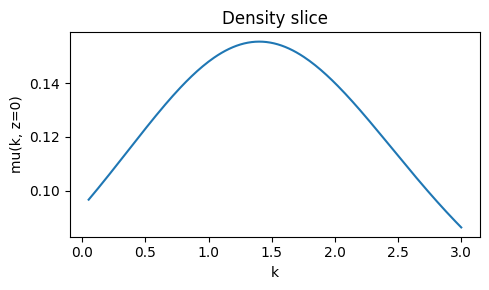

In [46]:

# Minimal plot: mu(k, z=0) slice
Vnet = eqx.combine(V_train, V_static)
Mnet = eqx.combine(M_train, M_static)

k_grid = jnp.linspace(k_min, k_max, 200)
z0 = jnp.zeros_like(k_grid)
mu_slice = Mnet(k_grid, z0)

plt.figure(figsize=(5,3))
plt.plot(np.asarray(k_grid), np.asarray(mu_slice))
plt.xlabel("k"); plt.ylabel("mu(k, z=0)")
plt.title("Density slice")
plt.tight_layout()
plt.show()


In [47]:

# SymPy: verify sup_i [(V_k - 1) i - (theta/2) * i^2 / k] equals k*(V_k-1)^2/(2 theta)
i, Vk, th, k = sp.symbols('i Vk th k', positive=True, finite=True)
expr = (Vk - 1)*i - (th/2) * i**2 / k
i_star = sp.diff(expr, i)
i_star = sp.simplify(sp.solve(sp.Eq(i_star, 0), i)[0])
value = sp.simplify(expr.subs(i, i_star))
sp.simplify(i_star), sp.simplify(value)
print("i* =", i_star)
print("Sup value =", value)


i* = k*(Vk - 1)/th
Sup value = k*(Vk - 1)**2/(2*th)



## References (Pointers)

- **HJB–FP coupling / HA macro in continuous time:** Achdou, Han, Lasry, Lions, Moll (2022), *Review of Economic Studies*, **89**(1):45–86.  
  See OUP version and NBER working paper for details and numerical treatment.

- **Reflecting (no‑flux) boundaries for Fokker–Planck:** Zero normal probability current \(J\cdot n=0\) on the boundary. Standard references include Gardiner’s *Stochastic Methods* (Fokker–Planck chapter) and common lecture notes.

- **Costly reversibility investment structure:** Abel & Eberly (1996), *Review of Economic Studies*, **63**(4):581–593. The quadratic structure implies closed‑form elimination of the control as shown in the SymPy cell.

- **Mesh‑free neural PDEs:** Sirignano & Spiliopoulos (2018) “DGM” (JCP); Raissi–Perdikaris–Karniadakis (2019) “PINNs” (JCP).

This notebook is intentionally minimal. It enforces **no‑flux** on all four walls for the FP equation via edge collocation, uses a small \( \sigma_k>0 \) to keep the FP operator strictly elliptic, and trains \(V\) and \(\mu\) in alternating phases with a damped price update in log‑space.


In [48]:
# Collocation sampling
def sample_interior(key, n):
    k = random.uniform(key, (n,), minval=kmin, maxval=kmax)
    z = random.uniform(random.split(key)[0], (n,), minval=-zmax, maxval=zmax)
    return k, z

def sample_edges(key, n):
    n_each = n//4
    key1, key2, key3, key4 = random.split(key, 4)
    ks = [
        jnp.full((n_each,), kmin),
        jnp.full((n_each,), kmax),
        random.uniform(key3, (n_each,), minval=kmin, maxval=kmax),
        random.uniform(key4, (n_each,), minval=kmin, maxval=kmax),
    ]
    zs = [
        random.uniform(key1, (n_each,), minval=-zmax, maxval=zmax),
        random.uniform(key2, (n_each,), minval=-zmax, maxval=zmax),
        jnp.full((n_each,), -zmax),
        jnp.full((n_each,), zmax),
    ]
    k_edge = jnp.concatenate(ks, axis=0)
    z_edge = jnp.concatenate(zs, axis=0)
    return k_edge, z_edge

# Losses
def losses(Vnet, Mnet, P, key):
    key_h, key_f, key_b, key_m = random.split(key, 4)
    k_h, z_h = sample_interior(key_h, 2000)
    k_f, z_f = sample_interior(key_f, 2000)
    k_b, z_b = sample_edges(key_b, 1000)
    k_m, z_m = sample_interior(key_m, 4000)

    hjb = vmap(lambda kk, zz: hjb_residual(Vnet, kk, zz, P))(k_h, z_h)
    fp = vmap(lambda kk, zz: fp_residual(Mnet, Vnet, kk, zz))(k_f, z_f)
    Jk_b, Jz_b = vmap(lambda kk, zz: currents(Mnet, Vnet, kk, zz))(k_b, z_b)

    # Mass by MC on the box
    mu_m = vmap(lambda kk, zz: Mnet(kk, zz))(k_m, z_m)
    area = (kmax - kmin)*(2*zmax)
    mass_hat = area * jnp.mean(mu_m)
    Lmass = (mass_hat - 1.0)**2

    Lhjb = jnp.mean(hjb**2)
    Lfp = jnp.mean(fp**2)
    # No-flux: zero current normal components
    # On k-edges, normal is ±e_k => enforce Jk=0; on z-edges enforce Jz=0
    
    # boundary segment sizes
    n_total = k_b.shape[0]
    n_each = n_total // 4
    # Segments: [k=kmin | k=kmax | z=-zmax | z=+zmax]
    Lbndry = (
        jnp.mean(Jk_b[0:n_each]**2) +
        jnp.mean(Jk_b[n_each:2*n_each]**2) +
        jnp.mean(Jz_b[2*n_each:3*n_each]**2) +
        jnp.mean(Jz_b[3*n_each:4*n_each]**2)
    )

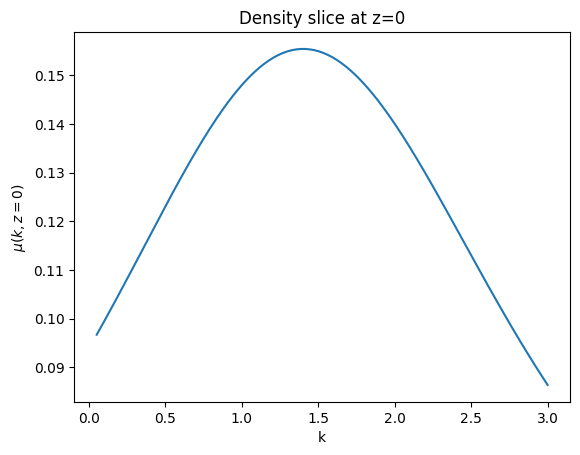

In [50]:
# Quick plot: density slice at z=0
ks = jnp.linspace(k_min, k_max, 200)
mu_slice = Mnet(ks, jnp.zeros_like(ks))
plt.figure()
plt.plot(np.array(ks), np.array(mu_slice))
plt.xlabel("k")
plt.ylabel(r"$\mu(k, z=0)$")
plt.title("Density slice at z=0")
plt.show()

## References (for theory & boundary conditions)

- Achdou, Han, Lasry, Lions, Moll (2022), *Income and Wealth Distribution in Macroeconomics: A Continuous-Time Approach*, **REStud** 89(1):45–86. Continuous-time HJB–FP coupling in heterogeneous-agent macro, steady-state systems on bounded domains with state-constraint boundaries.
- Abel & Eberly (1996), *Optimal Investment with Costly Reversibility*, **Review of Economic Studies** 63(4):581–593. Quadratic costly reversibility yields closed-form control $i^*$ and HJB conjugacy.
- Gardiner, *Stochastic Methods* (chapter on Fokker–Planck). Reflecting (no-flux) boundaries impose zero probability current $J\cdot n=0$.
- UCSD Physics 210B notes (Chapter 4, Fokker–Planck). Reflecting BCs: $J=0$ at the boundary.
- Sirignano & Spiliopoulos (2018), *Deep Galerkin Method*, **J. Comput. Phys.** Mesh-free collocation for PDEs.
- Raissi, Perdikaris, Karniadakis (2019), *Physics-Informed Neural Networks*, **J. Comput. Phys.**
